In [22]:
import pandas as pd
import missingno as msno
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [2]:
df = pd.read_csv("/Users/chenzizhang/Data Science/data/raw/vehicles.csv")

In [3]:
df.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,drive,size,type,paint_color,image_url,description,county,state,lat,long
0,7034441763,https://saltlakecity.craigslist.org/cto/d/salt...,salt lake city,https://saltlakecity.craigslist.org,17899,2012.0,volkswagen,golf r,excellent,4 cylinders,...,4wd,compact,hatchback,black,https://images.craigslist.org/00G0G_fTLDWM5Xyv...,PRICE REDUCED! -Garage kept -Low Miles (63K)...,NaN,ut,40.7372,-111.858
1,7034440610,https://saltlakecity.craigslist.org/ctd/d/sand...,salt lake city,https://saltlakecity.craigslist.org,0,2016.0,ford,f-150,excellent,NaN,...,4wd,NaN,NaN,NaN,https://images.craigslist.org/00v0v_7Cu0buIofU...,Drive it home today. Call (Or Text) us now !!C...,NaN,ut,40.5881,-111.884
2,7034440588,https://saltlakecity.craigslist.org/ctd/d/sand...,salt lake city,https://saltlakecity.craigslist.org,46463,2015.0,gmc,sierra 1500,excellent,NaN,...,4wd,NaN,NaN,white,https://images.craigslist.org/01515_lPvJ9bfbdY...,Drive it home today. Call (Or Text) us now !!C...,NaN,ut,40.5881,-111.884
3,7034440546,https://saltlakecity.craigslist.org/ctd/d/sand...,salt lake city,https://saltlakecity.craigslist.org,0,2016.0,ford,f-150,excellent,NaN,...,4wd,NaN,NaN,NaN,https://images.craigslist.org/00T0T_6Rjfp3NS4O...,Drive it home today. Call (Or Text) us now !!C...,NaN,ut,40.5881,-111.884
4,7034406932,https://saltlakecity.craigslist.org/ctd/d/evan...,salt lake city,https://saltlakecity.craigslist.org,49999,2018.0,ford,f-450,NaN,NaN,...,4wd,NaN,pickup,white,https://images.craigslist.org/00W0W_8yIUwRBXXd...,2018 Ford F-350 F350 F 350 SD Lariat Crew Cab ...,NaN,ut,40.3744,-104.694


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509577 entries, 0 to 509576
Data columns (total 25 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            509577 non-null  int64  
 1   url           509577 non-null  object 
 2   region        509577 non-null  object 
 3   region_url    509577 non-null  object 
 4   price         509577 non-null  int64  
 5   year          508050 non-null  float64
 6   manufacturer  486813 non-null  object 
 7   model         501588 non-null  object 
 8   condition     277643 non-null  object 
 9   cylinders     309894 non-null  object 
 10  fuel          505592 non-null  object 
 11  odometer      417253 non-null  float64
 12  title_status  506515 non-null  object 
 13  transmission  505858 non-null  object 
 14  vin           302152 non-null  object 
 15  drive         365434 non-null  object 
 16  size          167574 non-null  object 
 17  type          368046 non-null  object 
 18  pain

# 1. Check the data type of each feature

As the DataFrame shows, the data type of "year" column is float, however, it should be int. Since "year" column contains car's entry year. I can convert it into car's used time through using (2020-entry year) for further modeling.

Also, the data type of "cylinders" column (number of cylinders) should be int, but not object.

In [5]:
# Due to the existence of "NaN" value in "cylinders_num" column, it couldn't be converted into "int64" datatype.
# Thus I use pd.to_numeric() to convert it into datatype "float64".
df['cylinders_num'] = df['cylinders'].str[0]
df['cylinders_num'] = pd.to_numeric(df['cylinders_num'], errors='coerce')
df.drop('cylinders', axis=1, inplace=True)

In [6]:
# Since "year" column has less than 1% missing values. Thus, I chose to use row-deletion for datatype convertion.
df = df.dropna(subset=['year'])
df['vehicle age'] = 2020 - df['year']
df.drop('year', axis=1, inplace=True)
df['vehicle age'] = df['vehicle age'].astype('Int64')

# 2. Handling missing, Duplicates, Unnecessary values

## 2.1 Filtering Out Missing, Duplicates, Unnecessary values

In [7]:
df.isnull().sum()

id                    0
url                   0
region                0
region_url            0
price                 0
manufacturer      21240
model              7974
condition        230427
fuel               3440
odometer          92310
title_status       2712
transmission       3705
vin              207409
drive            143964
size             340494
type             141425
paint_color      164608
image_url             0
description           2
county           508050
state                 0
lat               10278
long              10278
cylinders_num    201131
vehicle age           0
dtype: int64

In [8]:
# Percentage of missing values in each column
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = df.isnull().sum() * 100 / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table = mis_val_table.rename(columns = {0:'Missing values', 1:'% of total values'})
    mis_val_table = mis_val_table.sort_values('% of total values',ascending=False)
    return mis_val_table

missing_values_table(df)

,Missing values,% of total values
county,508050,100.000000
size,340494,67.019782
condition,230427,45.355182
vin,207409,40.824525
cylinders_num,201131,39.588820
paint_color,164608,32.399961
drive,143964,28.336581
type,141425,27.836827
odometer,92310,18.169472
manufacturer,21240,4.180691


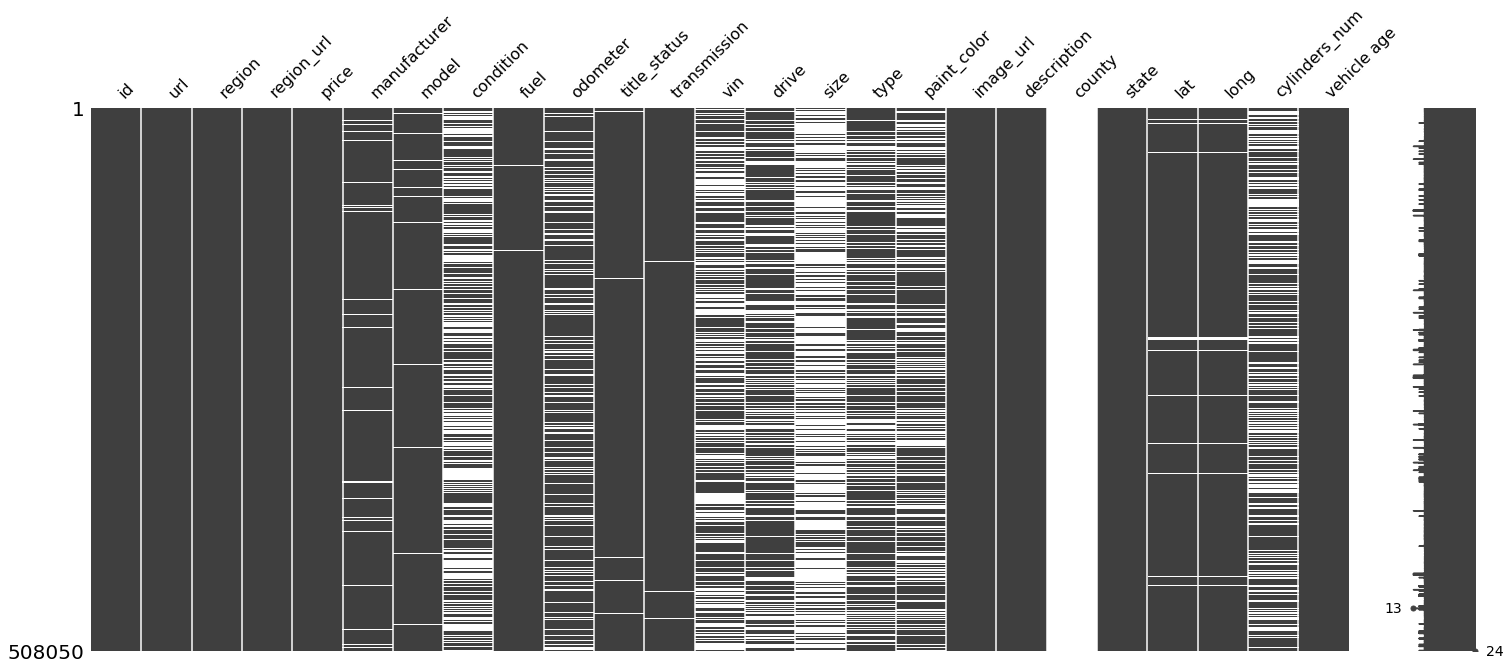

In [9]:
# matrix from missingno package could visualize the missing values in whole dataframe
msno.matrix(df)

Before removing unneccessary columns, we need to check whether each columns in the DataFrame has any $\color{red}{\text{duplicated}}$ records, especially in "id" column that duplicated id is not allowed to exist.

In [10]:
df.duplicated(subset='id').sum()
# This shows there is no duplicated records in DataFrame.

0

## 2.2 Discard Missing values

As we can see, the "county" column doesn't contain any data, thus I chose to use drop method to delete the whole column. Also, considering the high percentage of missing values in "size" column, I decided to delete it as well.

Besides, unnecessary columns like "id", "url", "region_url", "vin" (vehicle identification number), "image_url", "description" could be removed from the dataframe.

Moreover, "region" column contains relatively similar information in "lat" (latitude of listing) and "long" (longitude of listing) columns. Also. this column includes so many city names that is quite complex to deal with. Thus I also decided to drop the whole "region", "lat", and "long" columns.

Meanwhile, "model" column owns so many different models of vehicle that extremely increase the difficulty in categorical encoding, thus I delete this column as well.

In [11]:
# Let's move out the uncessary and fully empty columns.
df_1 = df.drop(columns=['id', 'model', 'county', 'size', 'url', 'region_url', 'vin', 'image_url', 'description', 'region', 'long', 'lat'])

In [12]:
missing_values_table(df_1)

,Missing values,% of total values
condition,230427,45.355182
cylinders_num,201131,39.588820
paint_color,164608,32.399961
drive,143964,28.336581
type,141425,27.836827
odometer,92310,18.169472
manufacturer,21240,4.180691
transmission,3705,0.729259
fuel,3440,0.677099
title_status,2712,0.533806


As for "title_status", "fuel", "transmission", "manufacturer" columns, the missing values in these columns only account no more than 5%, thus I decided to use row-deletion method.

In [13]:
df_1 = df_1.dropna(subset=['title_status', 'transmission', 'fuel', 'manufacturer'])

Besides, I noticed that in "price" column, some value equals 0, it's non-sense when price = 0 in used car price estimation. Thus, I chose to drop this kind of rows as well.

In [14]:
df_1 = df_1[~df_1['price'].isin([0])]

## 2.3 Missing values Imputation

### (1) Towards numerical columns

In [15]:
missing_values_table(df_1.select_dtypes(include=['int64', 'float64']).copy())

,Missing values,% of total values
cylinders_num,168366,38.504075
odometer,75712,17.314782
price,0,0.000000
vehicle age,0,0.000000


At first, let's deal with the missing value in "cylinders_num" column. From the following table and graph, as well as considering the datatype "Int64" of this column, I chose to use $\color{red}{\text{Mode}}$ to fill in the missing values.

In [16]:
df_1['cylinders_num'].describe()

count    268902.000000
mean          5.949647
std           1.641992
min           1.000000
25%           4.000000
50%           6.000000
75%           8.000000
max           8.000000
Name: cylinders_num, dtype: float64

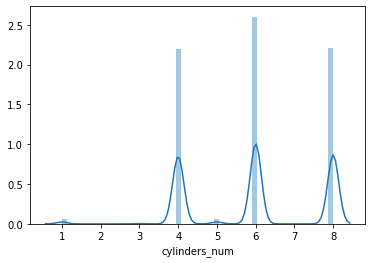

In [17]:
sns.distplot(df_1['cylinders_num'])

In [18]:
from sklearn.impute import SimpleImputer
imp_frequent = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
df_1['cylinders_num'] = imp_frequent.fit_transform(df_1[['cylinders_num']])

# Don't forget to change the datatype from float64 to Int64
df_1['cylinders_num'] = df_1['cylinders_num'].astype('Int64')
df_1 = df_1.reset_index(drop=True)

Next, let's do imputation towards the missing values in "odometer" column. One thing is to mention is that "odometer" column has large number of $\color{red}{\text{outliers}}$.

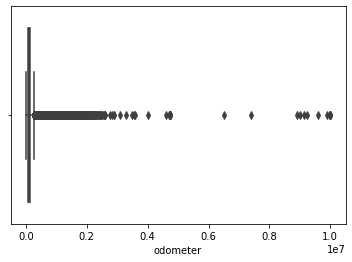

In [19]:
sns.boxplot(df_1['odometer'])

With so many outliers and nearly 17% of missing values, SimpleImputer is not optimal choice (no matter using mean, median and mode will bring noise into dataset. Thus, I consider using $\color{red}{\text{Multivariate}}$ imputation -- rely on other numerical columns to fill in the missing values.

In [23]:
imp = IterativeImputer(max_iter=10, random_state=0)
df_numerical = df_1[['cylinders_num', 'price', 'vehicle age', 'odometer']]
arr_1 = np.array(df_numerical)
arr_2 = imp.fit_transform(arr_1)
df_numerical_2 = pd.DataFrame(arr_2)
df_1['odometer'] = df_numerical_2[3]

### (2) Towards categorical columns

In [24]:
missing_values_table(df_1.select_dtypes(include=['object']).copy())

,Missing values,% of total values
condition,185903,42.514659
paint_color,137335,31.407512
drive,121080,27.690112
type,121028,27.678220
manufacturer,0,0.000000
fuel,0,0.000000
title_status,0,0.000000
transmission,0,0.000000
state,0,0.000000


For 'drive', 'condition', 'type' columns, I decided to changing all NaN values to $\color{red}{\text{"Unknown"}}$ category.

In [25]:
df_1['drive'] = df_1['drive'].fillna('Unknown')
df_1['condition'] = df_1['condition'].fillna('Unknown')
df_1['type'] = df_1['type'].fillna('Unknown')

As for "paint_color", I chose to use $\color{red}{\text{SimpleImputer Method}}$  to fill in the missing values in "paint_color" column since white is really a popular color.

In [26]:
df_1['paint_color'] = imp_frequent.fit_transform(df_1[['paint_color']])

In [27]:
df_1.isnull().sum()

price            0
manufacturer     0
condition        0
fuel             0
odometer         0
title_status     0
transmission     0
drive            0
type             0
paint_color      0
state            0
cylinders_num    0
vehicle age      0
dtype: int64

In [28]:
df_1.to_csv("/Users/chenzizhang/Data Science/data/interim/vehicles_1.csv", encoding='utf_8_sig', index=0)